In [3]:
import pyforest

In [4]:
data=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['class','message'])
# data source -> https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

# EDA

In [5]:
data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
class      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [8]:
data.isnull().sum()

class      0
message    0
dtype: int64

In [11]:
data['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

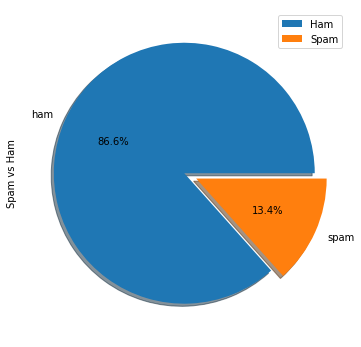

In [13]:
data["class"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

# Data cleaning & preprocessing 

In [20]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [21]:
ps = PorterStemmer()
corpus = []

In [25]:
#takes around 30-40 secs
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['message'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [36]:
print(type(corpus))
print(corpus[0:5])

<class 'list'>
['go jurong point crazi avail bugi n great world la e buffet cine got amor wat', 'ok lar joke wif u oni', 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli', 'u dun say earli hor u c alreadi say', 'nah think goe usf live around though']


In [37]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(corpus).toarray()

In [98]:
import pickle
pickle.dump(cv,open('transform.pkl','wb'))

In [38]:
y=pd.get_dummies(data['class'])
y=y.iloc[:,1].values

In [80]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [39]:
# Train Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Machine learning Model

In [40]:
# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

In [41]:
y_pred=spam_detect_model.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       955
           1       0.94      0.95      0.95       160

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115

[[946   9]
 [  8 152]]
0.9847533632286996


In [96]:
pickle.dump(spam_detect_model,file=open('spam_model.pkl','wb'))

# Trying TFIDF instead of CountVectorizer

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(corpus)
print(features.shape)

(5572, 6166)


In [81]:
X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features, y, stratify = y, test_size = 0.2)

In [83]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

In [84]:
rfc.fit(X_train1,y_train1)

C:\Users\akashmas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
rfc_pred=rfc.predict(X_test1)

In [87]:
print(classification_report(y_test1,rfc_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.83      0.89       149

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[[962   4]
 [ 26 123]]
